C:\Users\10075\AppData\Local\Temp\ipykernel_6932\368872528.py:13: DtypeWarning: Columns (4,5,6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)
c:\Users\10075\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 1 is smaller than n_iter=100. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


LinearRegression 最佳参数: {}


c:\Users\10075\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 10 is smaller than n_iter=100. Running 10 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Ridge 最佳参数: {'alpha': 0.46415888336127775}


c:\Users\10075\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 10 is smaller than n_iter=100. Running 10 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Lasso 最佳参数: {'alpha': 46.41588833612773}


c:\Users\10075\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 90 is smaller than n_iter=100. Running 90 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Users\10075\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.540e+17, tolerance: 9.356e+14
  model = cd_fast.enet_coordinate_descent(


ElasticNet 最佳参数: {'l1_ratio': 0.9, 'alpha': 0.001}
SVR 最佳参数: {'kernel': 'linear', 'gamma': 0.0021544346900318843, 'C': 100.0}
-------------------------------------------------------


c:\Users\10075\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.540e+17, tolerance: 9.356e+14
  model = cd_fast.enet_coordinate_descent(
c:\Users\10075\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.024e+17, tolerance: 7.529e+14
  model = cd_fast.enet_coordinate_descent(
c:\Users\10075\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the sca

LinearRegression - 计算均方误差 (MSE): 60926064324534.96
LinearRegression - 计算决定系数 (R²): 0.8364926531722634


C:\Users\10075\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 20064 (\N{CJK UNIFIED IDEOGRAPH-4E60}) missing from font(s) MS Gothic.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\10075\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 32447 (\N{CJK UNIFIED IDEOGRAPH-7EBF}) missing from font(s) MS Gothic.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\10075\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 35757 (\N{CJK UNIFIED IDEOGRAPH-8BAD}) missing from font(s) MS Gothic.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\10075\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 32451 (\N{CJK UNIFIED IDEOGRAPH-7EC3}) missing from font(s) MS Gothic.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\10075\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: Us

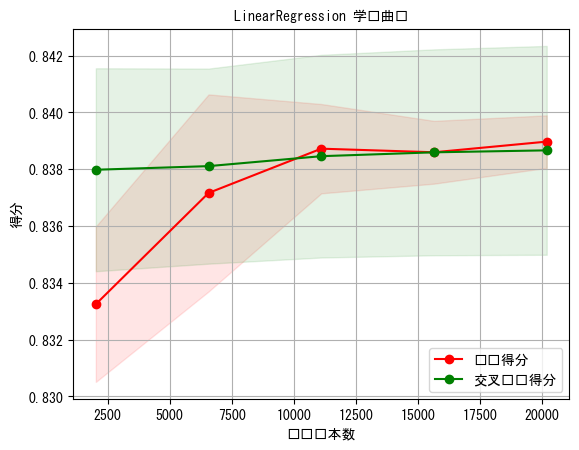

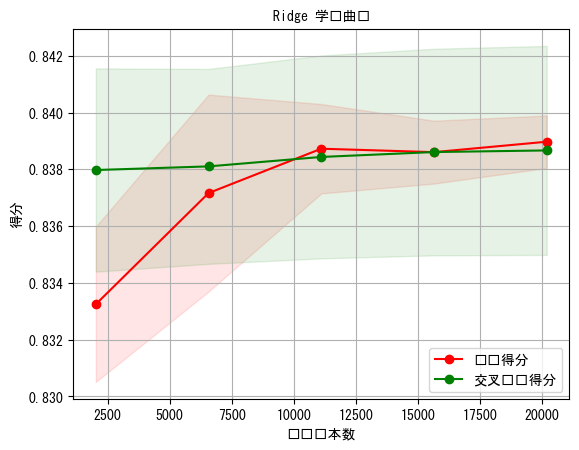

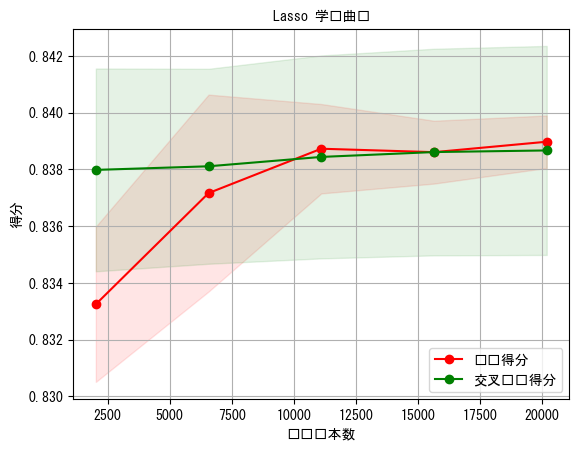

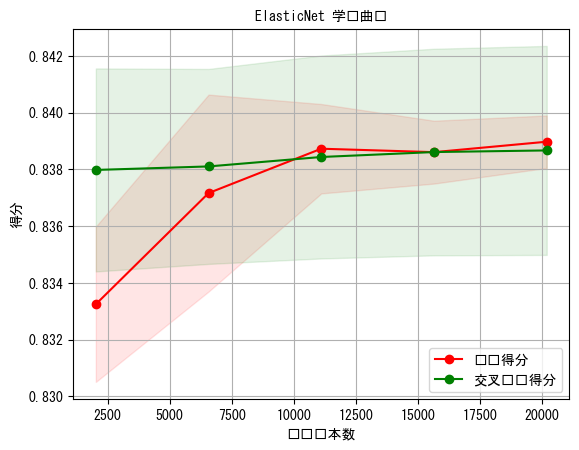

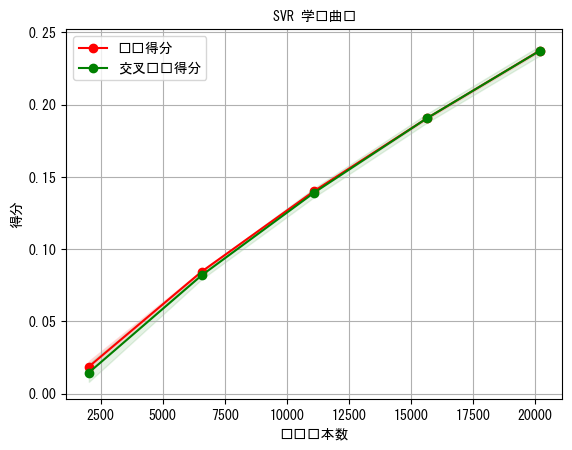

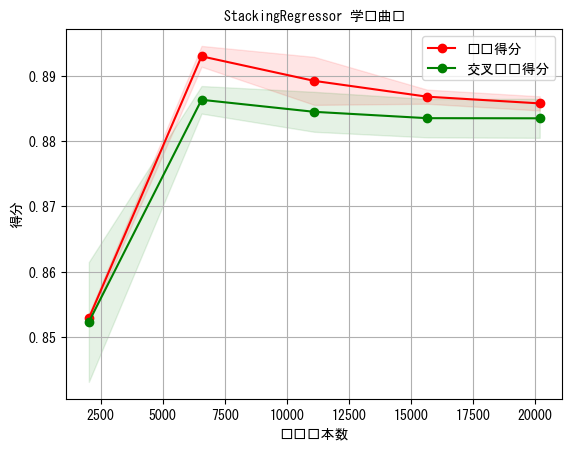

C:\Users\10075\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 39044 (\N{CJK UNIFIED IDEOGRAPH-9884}) missing from font(s) MS Gothic.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\10075\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 27979 (\N{CJK UNIFIED IDEOGRAPH-6D4B}) missing from font(s) MS Gothic.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\10075\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 32467 (\N{CJK UNIFIED IDEOGRAPH-7ED3}) missing from font(s) MS Gothic.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\10075\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 23454 (\N{CJK UNIFIED IDEOGRAPH-5B9E}) missing from font(s) MS Gothic.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\10075\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: Us

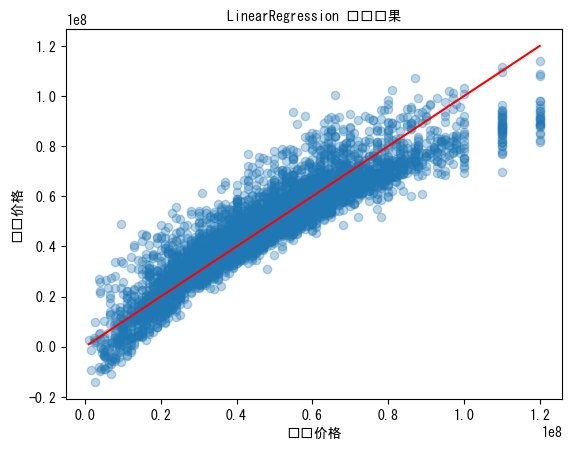

C:\Users\10075\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 39044 (\N{CJK UNIFIED IDEOGRAPH-9884}) missing from font(s) MS Gothic.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\10075\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 27979 (\N{CJK UNIFIED IDEOGRAPH-6D4B}) missing from font(s) MS Gothic.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\10075\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 32467 (\N{CJK UNIFIED IDEOGRAPH-7ED3}) missing from font(s) MS Gothic.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\10075\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 23454 (\N{CJK UNIFIED IDEOGRAPH-5B9E}) missing from font(s) MS Gothic.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\10075\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: Us

Ridge - 计算均方误差 (MSE): 60925609701924.14
Ridge - 计算决定系数 (R²): 0.8364938732434715


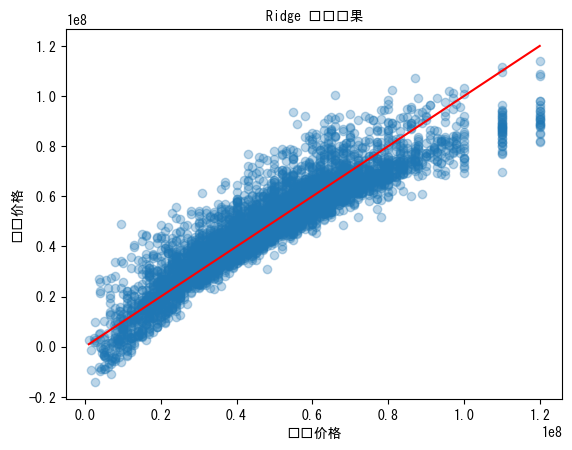

Lasso - 计算均方误差 (MSE): 60926060625022.945
Lasso - 计算决定系数 (R²): 0.836492663100648


C:\Users\10075\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 39044 (\N{CJK UNIFIED IDEOGRAPH-9884}) missing from font(s) MS Gothic.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\10075\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 27979 (\N{CJK UNIFIED IDEOGRAPH-6D4B}) missing from font(s) MS Gothic.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\10075\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 32467 (\N{CJK UNIFIED IDEOGRAPH-7ED3}) missing from font(s) MS Gothic.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\10075\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 23454 (\N{CJK UNIFIED IDEOGRAPH-5B9E}) missing from font(s) MS Gothic.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\10075\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: Us

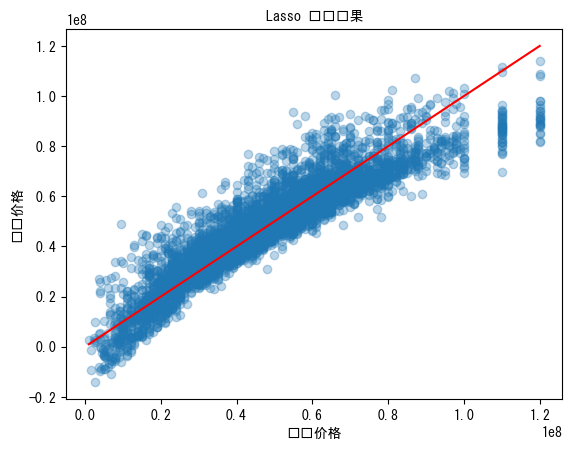

ElasticNet - 计算均方误差 (MSE): 60923603642558.41
ElasticNet - 计算决定系数 (R²): 0.8364992569072303


C:\Users\10075\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 39044 (\N{CJK UNIFIED IDEOGRAPH-9884}) missing from font(s) MS Gothic.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\10075\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 27979 (\N{CJK UNIFIED IDEOGRAPH-6D4B}) missing from font(s) MS Gothic.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\10075\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 32467 (\N{CJK UNIFIED IDEOGRAPH-7ED3}) missing from font(s) MS Gothic.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\10075\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 23454 (\N{CJK UNIFIED IDEOGRAPH-5B9E}) missing from font(s) MS Gothic.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\10075\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: Us

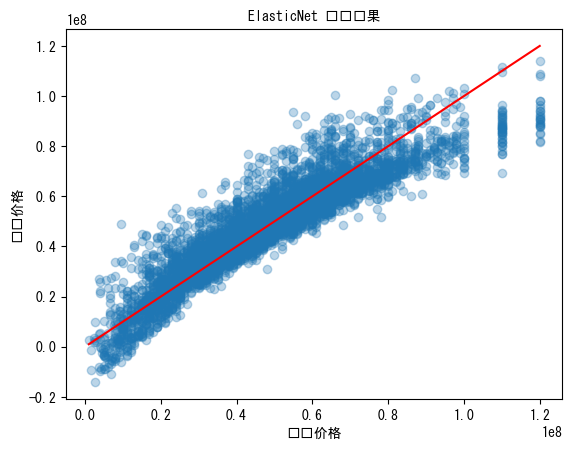

SVR - 计算均方误差 (MSE): 267473446251997.28
SVR - 计算决定系数 (R²): 0.2821812137646381


C:\Users\10075\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 39044 (\N{CJK UNIFIED IDEOGRAPH-9884}) missing from font(s) MS Gothic.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\10075\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 27979 (\N{CJK UNIFIED IDEOGRAPH-6D4B}) missing from font(s) MS Gothic.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\10075\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 32467 (\N{CJK UNIFIED IDEOGRAPH-7ED3}) missing from font(s) MS Gothic.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\10075\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 23454 (\N{CJK UNIFIED IDEOGRAPH-5B9E}) missing from font(s) MS Gothic.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\10075\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: Us

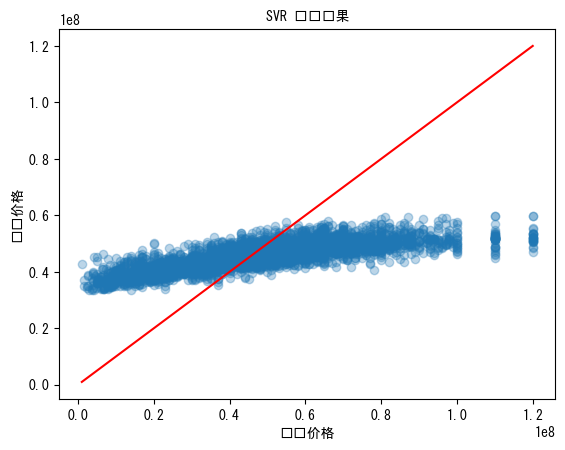

StackingRegressor - 计算均方误差 (MSE): 45918473659118.68
StackingRegressor - 计算决定系数 (R²): 0.876768540991112


C:\Users\10075\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 39044 (\N{CJK UNIFIED IDEOGRAPH-9884}) missing from font(s) MS Gothic.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\10075\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 27979 (\N{CJK UNIFIED IDEOGRAPH-6D4B}) missing from font(s) MS Gothic.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\10075\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 32467 (\N{CJK UNIFIED IDEOGRAPH-7ED3}) missing from font(s) MS Gothic.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\10075\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 23454 (\N{CJK UNIFIED IDEOGRAPH-5B9E}) missing from font(s) MS Gothic.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\10075\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: Us

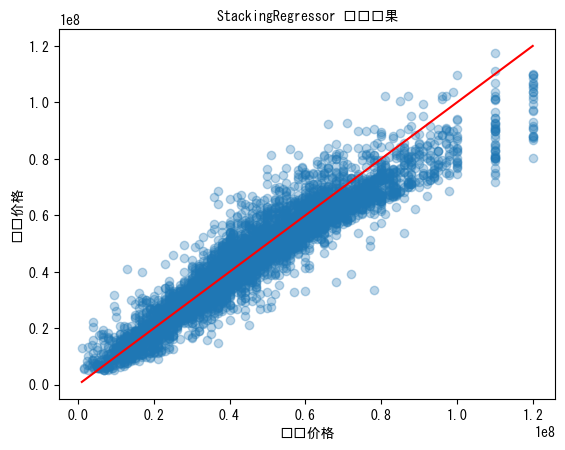

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.ensemble import StackingRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score

# 加载数据集
file_path = 'E:\\AI\\0705fix Tokyo house price.csv'
df = pd.read_csv(file_path)

# 设置日文字体为Windows系统自带的MS Gothic字体
plt.rcParams['font.sans-serif'] = ['MS Gothic']
plt.rcParams['axes.unicode_minus'] = False

# 筛选出'取引時期'列中包含2018年至2023年的数据
df['取引時期'] = df['取引時期'].astype(str)
filtered_df = df[df['取引時期'].str.contains(r'202[0-3]|201[8-9]', regex=True)]
filtered_df = filtered_df.query('種類 == "宅地(土地と建物)"')
filtered_df = filtered_df.query('今後の利用目的 == "住宅"')

selected_columns = ['区の平均世帯年収:円', '価格相場：円', '家賃相場：円', '最寄駅：距離（分）', '取引価格（総額）', '面積（㎡）', '取引価格（㎡単価）', '間口', '延床面積（㎡）', '建築年', '築年数', '建物の構造評価', '方位評価', '前面道路：幅員（ｍ）', '建ぺい率（％）', '容積率（％）']
selected_df = filtered_df[selected_columns]

# 转换为数值类型
selected_df = selected_df.apply(pd.to_numeric, errors='coerce')

# 处理缺失值
selected_df.fillna(selected_df.median(), inplace=True)

# 计算IQR并过滤异常值
Q1 = selected_df.quantile(0.25)
Q3 = selected_df.quantile(0.75)
IQR = Q3 - Q1
is_outlier = (selected_df < (Q1 - 1.5 * IQR)) | (selected_df > (Q3 + 1.5 * IQR))
data_cleaned = selected_df[~is_outlier.any(axis=1)]

# 数据预处理
X = data_cleaned.drop('取引価格（総額）', axis=1)
y = data_cleaned['取引価格（総額）']

# 划分数据集为训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 特征标准化
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# 定义要评估的模型和参数
models = {
    'LinearRegression': LinearRegression(),
    'Ridge': Ridge(),
    'Lasso': Lasso(),
    'ElasticNet': ElasticNet(),
    'SVR': SVR()
}

# 设置更广泛的参数范围和细的步长
params = {
    'LinearRegression': {},
    'Ridge': {'alpha': np.logspace(-3, 3, 10)},
    'Lasso': {'alpha': np.logspace(-3, 3, 10)},
    'ElasticNet': {'alpha': np.logspace(-3, 3, 10), 'l1_ratio': np.linspace(0.1, 0.9, 9)},
    'SVR': {'C': np.logspace(-2, 2, 10), 'gamma': np.logspace(-3, 0, 10), 'kernel': ['linear', 'rbf']}
}

# 进行随机搜索和交叉验证
best_estimators = {}
for name, model in models.items():
    random_search = RandomizedSearchCV(model, params[name], n_iter=100, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, random_state=42)
    random_search.fit(X_train, y_train)
    best_estimators[name] = random_search.best_estimator_
    print(f'{name} 最佳参数: {random_search.best_params_}')
print('-------------------------------------------------------')

# 添加集成模型
stacked_model = StackingRegressor(
    estimators=[(name, est) for name, est in best_estimators.items()],
    final_estimator=GradientBoostingRegressor(n_estimators=100, random_state=42)
)

stacked_model.fit(X_train, y_train)

# 可视化学习曲线
def plot_learning_curve(estimator, title, X, y, cv=5, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title, fontproperties='MS Gothic')
    plt.xlabel("训练样本数", fontproperties='MS Gothic')
    plt.ylabel("得分", fontproperties='MS Gothic')
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="训练得分")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="交叉验证得分")

    plt.legend(loc="best")
    return plt

# 绘制每个模型的学习曲线
for name, estimator in best_estimators.items():
    plot_learning_curve(estimator, f'{name} 学习曲线', X_train, y_train)

# 绘制集成模型的学习曲线
plot_learning_curve(stacked_model, 'StackingRegressor 学习曲线', X_train, y_train)

# 评估每个模型的性能并进行可视化
for name, model in best_estimators.items():
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f'{name} - 计算均方误差 (MSE): {mse}')
    print(f'{name} - 计算决定系数 (R²): {r2}')
    plt.figure()
    plt.scatter(y_test, y_pred, alpha=0.3)
    plt.xlabel("实际价格", fontproperties='MS Gothic')
    plt.ylabel("预测价格", fontproperties='MS Gothic')
    plt.title(f'{name} 预测结果', fontproperties='MS Gothic')
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')
    plt.show()

# 评估集成模型的性能并进行可视化
y_pred = stacked_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'StackingRegressor - 计算均方误差 (MSE): {mse}')
print(f'StackingRegressor - 计算决定系数 (R²): {r2}')
plt.figure()
plt.scatter(y_test, y_pred, alpha=0.3)
plt.xlabel("实际价格", fontproperties='MS Gothic')
plt.ylabel("预测价格", fontproperties='MS Gothic')
plt.title('StackingRegressor 预测结果', fontproperties='MS Gothic')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')
plt.show()
